# ART calculations for `VEEV` virus

In [16]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [17]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [18]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/VEEV_bestMACAW/'
os.makedirs(artResultDir, exist_ok=True)
saveDir = os.path.join(resultsDir, "VEEV/")
#saveDir = os.path.join(resultsDir, "VEEV_bestMACAW/")
os.makedirs(saveDir, exist_ok=True)

### Extract the data for `Marburg` into a data frame with `duplicate` SMILES

In [7]:
VEEVVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "VEEVVirusData_chEMBL_wMACAW.csv")
VEEVVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,...,MACAW_36,MACAW_37,MACAW_38,MACAW_39,MACAW_40,MACAW_41,MACAW_42,MACAW_43,MACAW_44,MACAW_45
0,1,CHEMBL5088695,COc1ccc(Nc2ccnc3ccc(C(F)(F)F)cc23)c(OC)c1,5.468521,VEEV,-0.261089,0.330286,0.054564,0.034558,0.075892,...,-0.036892,-0.061672,-0.059537,0.032906,0.149954,-0.462452,-0.250739,-0.048942,0.031680,-0.000006
1,7,CHEMBL3186763,CN1CCN(C)/C(=N/c2ccc([N+](=O)[O-])cc2C(=O)Nc2c...,6.769551,VEEV,0.284708,0.000118,-0.198729,-0.297278,-0.134716,...,-0.060222,-0.080192,-0.015434,0.036111,0.003031,0.070108,0.002445,-0.043959,0.384866,0.000011
2,8,CHEMBL1336,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,5.431798,VEEV,-0.134064,0.093221,0.012431,0.108114,-0.019095,...,-0.043178,0.046036,0.040138,-0.018596,-0.024298,-0.065847,-0.029837,0.069066,-0.288350,-0.000009
3,11,CHEMBL3342041,CN1CCN(C)/C(=N/c2ccc(C(F)(F)F)cc2C(=O)Nc2ccccc...,4.651695,VEEV,0.057813,0.153111,-0.155025,-0.230570,-0.033308,...,-0.107571,-0.056550,-0.227372,0.013612,0.223694,0.006053,0.430737,0.142525,0.140988,0.000005
4,12,CHEMBL3342043,CN1CCN(C)/C(=N/c2ccc(C#N)cc2C(=O)Nc2ccccc2F)C1,5.431798,VEEV,0.090881,0.104600,-0.267331,-0.128272,0.068302,...,0.208872,0.119205,0.057052,-0.108293,0.317054,0.186390,0.047021,0.157755,0.866520,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,203,CHEMBL5071224,FC(F)(F)c1ccc2nccc(Nc3ccc(Br)cc3)c2c1,5.200659,VEEV,-0.241873,0.385931,0.176309,-0.000392,-0.105384,...,0.009421,-0.015536,0.326725,0.171636,0.134898,-0.091464,-0.179886,-0.099560,0.618361,-0.000012
139,204,CHEMBL5078159,COc1cccc(Nc2ccnc3cc(OC)c(OC)cc23)c1,5.318759,VEEV,-0.228650,0.186507,-0.066318,0.082226,0.211782,...,-0.079893,0.054296,-0.057892,-0.129658,-0.052536,0.040879,-0.336648,0.089625,-0.034172,-0.000007
140,206,CHEMBL5077889,COc1ccc(N2C(=O)c3cc([N+](=O)[O-])ccc3N=C3C2N(C...,5.522879,VEEV,0.100190,-0.033863,-0.118960,0.323236,-0.108596,...,0.093667,-0.094488,0.084818,-0.063179,-0.105616,0.037299,-0.155554,0.150437,-0.055875,0.000001
141,208,CHEMBL5080706,COc1ccc(N2C(=O)c3cc(C#N)cc(-c4ccc(C)nc4)c3N=C3...,6.301030,VEEV,-0.021285,0.029562,-0.185218,0.376140,0.076134,...,-0.143430,0.108085,0.063847,0.122167,0.392003,-0.184688,0.301036,0.062727,0.328176,-0.000003


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [8]:
input_var = [col for col in VEEVVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 45
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15', 'MACAW_16', 'MACAW_17', 'MACAW_18', 'MACAW_19', 'MACAW_20', 'MACAW_21', 'MACAW_22', 'MACAW_23', 'MACAW_24', 'MACAW_25', 'MACAW_26', 'MACAW_27', 'MACAW_28', 'MACAW_29', 'MACAW_30', 'MACAW_31', 'MACAW_32', 'MACAW_33', 'MACAW_34', 'MACAW_35', 'MACAW_36', 'MACAW_37', 'MACAW_38', 'MACAW_39', 'MACAW_40', 'MACAW_41', 'MACAW_42', 'MACAW_43', 'MACAW_44', 'MACAW_45']


In [9]:
features = VEEVVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [10]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [11]:
response = VEEVVirusData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [12]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'VEEVVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [13]:
VEEVVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "VEEVVirusData_chEMBL_wMACAW_ARTready.csv")
VEEVVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.261089
1,1,MACAW_1,0.284708
2,2,MACAW_1,-0.134064
3,3,MACAW_1,0.057813
4,4,MACAW_1,0.090881
...,...,...,...
6573,138,pPotency,5.200659
6574,139,pPotency,5.318759
6575,140,pPotency,5.522879
6576,141,pPotency,6.301030


### Define the ART parameters needed for the prediction

In [14]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 143 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_regressor
is_

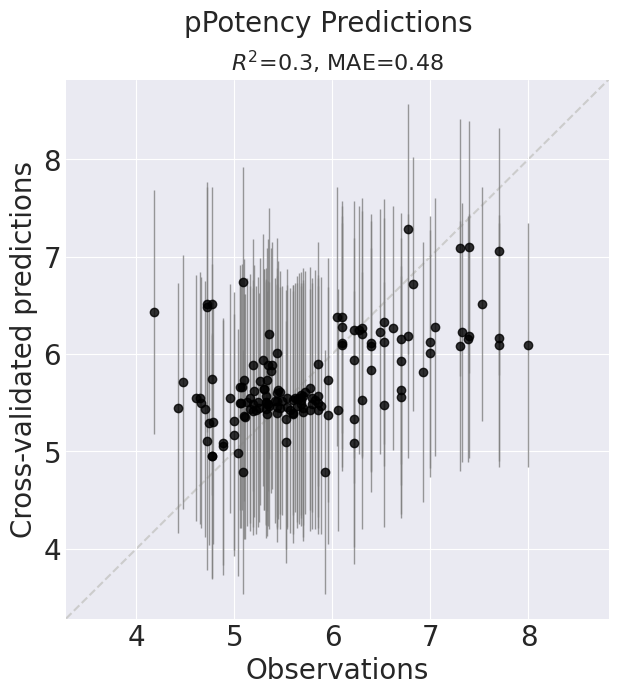

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
i

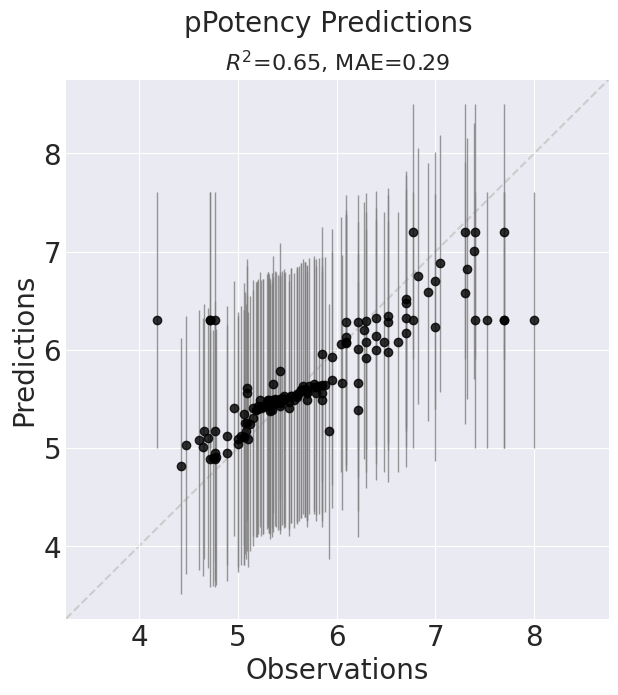

CPU times: user 16min 34s, sys: 2.35 s, total: 16min 36s
Wall time: 1h 7min 3s


In [15]:
%%time

art = RecommendationEngine(df=VEEVVirusData_chEMBL_wMACAW_ARTready, **art_params)

In [17]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [18]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [17]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

 ART model loaded from: /code/DTRA_ART/DrugDesignData/Results/ART_results/VEEV/art.cpkl


### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [13]:
VEEVVirus_EnamineDatasets_wMACAW = pd.read_csv(saveDir + "/VEEV_EnamineDataset_wMACAW.csv")
VEEVVirus_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,-0.133527,-0.005667,0.050360,0.119056,0.061626,0.030726,-0.085343,0.126727,0.046675,0.042523,-0.055821,0.018226,0.027625,0.043130,0.067027
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,-0.120841,-0.056887,0.080283,0.069024,0.055080,0.050443,-0.078513,0.159922,-0.007627,0.082748,-0.071925,0.040899,-0.006506,0.029439,0.023160
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,-0.038077,-0.011678,0.072973,0.098708,0.113868,0.069871,-0.056818,0.102723,-0.025960,-0.003590,-0.062867,-0.006441,-0.000154,0.031129,0.097199
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,-0.086995,-0.001207,0.044776,0.141839,0.075169,0.087338,-0.046877,0.142216,-0.013408,0.004759,-0.019872,0.026097,0.045126,0.019024,0.042492
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,-0.039044,-0.048022,0.088051,0.031289,0.092546,0.079324,-0.028519,0.134031,-0.010212,-0.005773,-0.035674,-0.011393,0.022324,0.017353,-0.007552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,-0.052737,-0.014818,0.046961,0.086991,0.071807,0.100287,-0.095281,0.125532,-0.023090,0.005308,-0.072823,0.022351,-0.023463,0.075659,0.075760
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,-0.134589,-0.005889,0.035784,0.113248,0.020696,0.041283,-0.063172,0.112169,0.097816,0.033091,-0.058147,0.045301,0.035790,0.039119,0.001193
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,-0.100514,0.004039,0.070801,0.115638,0.032311,0.052278,-0.074718,0.120469,-0.003161,-0.007100,0.001061,0.000988,-0.000284,0.026462,0.055897
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,-0.044668,-0.035604,0.078670,0.128877,0.036691,0.041738,-0.054744,0.127756,0.019462,-0.009885,-0.019669,-0.012957,0.025871,0.018776,0.074241


In [14]:
macaw_columns = [col for col in VEEVVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = VEEVVirus_EnamineDatasets_wMACAW[macaw_columns].values

In [15]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

array([[5.4624655 ],
       [5.42043289],
       [5.46530309],
       ...,
       [5.45148138],
       [5.4600871 ],
       [5.45563987]])

Get predictions with uncertainty using ART's post_pred_stats

In [16]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = VEEVVirus_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/VEEV_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/VEEV_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,5.462466,0.638903,4.210216,6.714715,0.000003,1.928790e-07,0.000062
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,5.420433,0.640142,4.165755,6.675110,0.000004,2.112952e-07,0.000068
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,5.465303,0.640450,4.210022,6.720584,0.000003,1.902899e-07,0.000062
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,5.449343,0.639960,4.195021,6.703666,0.000004,1.978493e-07,0.000064
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,5.427987,0.642609,4.168474,6.687500,0.000004,2.053524e-07,0.000068
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,5.441912,0.639293,4.188898,6.694927,0.000004,2.018705e-07,0.000065
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,5.456893,0.639078,4.204301,6.709486,0.000003,1.952155e-07,0.000062
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,5.451481,0.639506,4.198050,6.704913,0.000004,1.972820e-07,0.000063
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,5.460087,0.639777,4.206124,6.714050,0.000003,1.931745e-07,0.000062


## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [17]:
VEEVVirus_LCAntiviralsData_wMACAW = pd.read_csv(saveDir + "/VEEV_LCAntiviralsData_wMACAW.csv")
VEEVVirus_LCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,-0.050599,-0.000937,0.095719,0.119420,0.052557,0.071694,-0.097031,0.175670,0.003781,0.048829,-0.073211,-0.001181,-0.023222,0.020317,0.037760
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,-0.078026,0.048855,0.114209,0.108997,-0.008781,0.034882,-0.060874,0.159606,-0.003460,-0.013591,-0.038475,0.024332,0.006209,-0.038470,0.058268
2,CN1CCCN(Cc2ccncc2)CC1,-0.069743,0.018902,0.093972,0.101543,0.054573,0.090913,-0.048612,0.111581,0.029682,0.016733,-0.068468,-0.009927,0.033477,-0.052923,0.025252
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,-0.083703,0.009170,0.059534,0.120528,0.000223,0.026777,-0.041228,0.127901,0.022012,0.014399,-0.052678,0.011526,0.018450,-0.010748,0.058312
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,-0.105718,0.036891,0.106305,0.129099,0.021404,0.076441,-0.061319,0.160410,0.040458,0.024988,-0.051992,0.018998,-0.010552,0.019884,0.056442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,-0.102055,-0.002893,-0.006841,0.040179,0.018530,0.083702,-0.093813,0.014319,-0.042746,0.004349,-0.011891,-0.001132,-0.003459,-0.007669,-0.042782
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,-0.058309,-0.004877,0.021884,0.072514,0.024196,0.093721,-0.082611,0.041879,-0.038219,-0.018987,0.002446,0.017668,-0.000463,0.004685,0.014425
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,-0.171243,0.057297,0.014905,0.108958,0.060670,0.013136,-0.096032,-0.004581,0.025350,0.015409,-0.090820,0.047743,0.061600,-0.008605,-0.007194
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,-0.051532,-0.020004,0.001808,0.129954,0.008155,0.123883,-0.103182,0.035483,-0.070964,-0.076254,0.046265,0.039472,0.016297,-0.021351,0.041096


In [18]:
macaw_columns = [col for col in VEEVVirus_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = VEEVVirus_LCAntiviralsData_wMACAW[macaw_columns].values

In [19]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.40535557],
       [5.43540784],
       [5.45317899],
       ...,
       [5.47297311],
       [5.42210275],
       [5.44740141]])

Get predictions with uncertainty using ART's post_pred_stats

In [20]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = VEEVVirus_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/VEEV_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/VEEV_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,5.405356,0.640301,4.150365,6.660346,0.000004,2.186017e-07,0.000071
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,5.435408,0.639522,4.181945,6.688871,0.000004,2.047055e-07,0.000066
2,CN1CCCN(Cc2ccncc2)CC1,5.453179,0.641549,4.195743,6.710615,0.000004,1.947084e-07,0.000064
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,5.465107,0.639572,4.211545,6.718668,0.000003,1.911312e-07,0.000061
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,5.433270,0.639171,4.180494,6.686046,0.000004,2.060413e-07,0.000066
...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,5.275196,0.641308,4.018232,6.532160,0.000005,2.936567e-07,0.000096
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,5.441466,0.640774,4.185549,6.697384,0.000004,2.007319e-07,0.000065
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,5.472973,0.639075,4.220387,6.725559,0.000003,1.881224e-07,0.000060
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,5.422103,0.639538,4.168608,6.675597,0.000004,2.110585e-07,0.000068


## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [21]:
VEEVVirus_ChemDivAntiviralsData_wMACAW = pd.read_csv(saveDir + "/VEEV_ChemDivAntiviralsData_wMACAW.csv")
VEEVVirus_ChemDivAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,-0.029524,-0.002703,-0.036243,0.153949,0.061632,0.107694,-0.061203,0.040669,-0.041837,0.016739,0.032899,0.017612,0.022307,0.037146,0.073889
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,-0.010089,0.007539,0.053867,0.122561,0.082462,0.141113,-0.051160,0.086102,-0.041625,-0.013463,0.012814,0.002021,0.038502,-0.005179,0.029358
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,-0.055438,-0.001586,-0.084693,0.207592,0.091915,0.105521,-0.073556,0.037121,-0.040065,-0.007470,0.038996,-0.050224,0.001341,0.041072,0.051323
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,-0.098348,-0.010662,0.010900,0.049244,0.048265,0.054838,-0.092983,0.031725,-0.051052,0.049260,0.022631,0.059142,0.030215,0.024281,0.056883
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,-0.020773,0.012591,0.063310,0.100364,0.039561,0.153537,-0.126467,0.054264,-0.105073,0.023371,0.037964,0.032698,0.000013,0.025957,0.021059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64953,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,-0.085249,0.046840,0.053762,0.135481,0.056976,0.063574,-0.090849,0.029827,-0.042352,-0.080009,0.095601,0.036119,0.037995,0.034542,0.057168
64954,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,-0.096168,0.045351,0.056705,0.119181,0.049669,0.063196,-0.107385,0.036280,-0.057221,-0.038901,0.091456,0.032351,0.031186,0.009416,0.059155
64955,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,-0.075495,0.037074,0.047349,0.108512,0.053736,0.061834,-0.097055,0.046564,-0.036565,-0.064069,0.085205,0.036925,0.025944,-0.003600,0.052267
64956,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,-0.131109,0.085736,0.011358,0.156502,0.054276,0.037958,-0.084260,-0.004534,0.003212,-0.083739,0.107713,0.067416,0.039096,0.035249,0.042643


In [22]:
macaw_columns = [col for col in VEEVVirus_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = VEEVVirus_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [23]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.48850799],
       [5.45515766],
       [5.48255328],
       ...,
       [5.42697805],
       [5.49429664],
       [5.48667178]])

Get predictions with uncertainty using ART's post_pred_stats

In [24]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = VEEVVirus_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/VEEV_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/VEEV_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,5.488508,0.639347,4.235387,6.741629,0.000003,1.812888e-07,0.000058
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,5.455158,0.640680,4.199424,6.710891,0.000004,1.945849e-07,0.000063
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,5.482553,0.638797,4.230512,6.734595,0.000003,1.842490e-07,0.000059
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,5.441259,0.639594,4.187654,6.694863,0.000004,2.019001e-07,0.000065
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,5.353148,0.640320,4.098121,6.608174,0.000004,2.465049e-07,0.000080
...,...,...,...,...,...,...,...,...
64953,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,5.482528,0.639684,4.228748,6.736308,0.000003,1.835237e-07,0.000059
64954,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,5.441606,0.639397,4.188388,6.694824,0.000004,2.019183e-07,0.000065
64955,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,5.426978,0.639604,4.173354,6.680602,0.000004,2.086401e-07,0.000067
64956,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,5.494297,0.639328,4.241213,6.747380,0.000003,1.789041e-07,0.000057


### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [25]:
VEEVVirus_SMACCAntiviralsData_wMACAW = pd.read_csv(saveDir + "/VEEV_SMACCAntiviralsData_wMACAW.csv")
VEEVVirus_SMACCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,-0.140165,-0.000429,0.057770,0.092476,-0.012186,0.038037,-0.119228,0.079505,0.037140,0.107889,-0.008623,0.075194,0.041985,0.036926,0.019704
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,-0.160852,0.036445,0.063522,0.133494,-0.033234,0.072430,-0.216216,-0.021227,-0.027702,0.102227,0.023963,0.028260,-0.032013,0.001877,-0.006572
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,-0.112907,0.060732,0.065978,0.133942,0.021379,0.042316,-0.095258,0.030745,0.038915,0.056200,-0.006625,0.083631,0.046986,-0.033946,0.013688
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,-0.152811,0.023396,0.092893,0.073886,0.027211,0.048077,-0.059146,0.120640,0.014112,0.126929,-0.035533,0.025218,0.074057,-0.049184,0.023137
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,-0.135402,-0.019862,0.008696,0.114135,-0.045262,0.098588,-0.137194,0.012092,-0.047533,0.104026,0.034805,0.105276,0.044037,-0.039571,0.011178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,-0.167886,0.093494,0.085874,0.087026,0.003600,0.039188,-0.068826,0.104658,0.072714,0.086859,-0.035042,0.041779,0.048772,0.010463,0.032791
1608,S=C1Nc2ccccc2S1,-0.161336,0.069736,0.101983,0.112240,0.011454,0.046755,-0.070726,0.113459,0.054706,0.061264,-0.045824,0.043032,0.037066,-0.014863,0.028575
1609,SC(=S)N1CCCC1,-0.120671,0.015436,0.081374,0.110463,0.024965,0.037908,-0.068309,0.138345,0.029156,0.016304,-0.029129,0.038802,0.024828,-0.006557,0.040274
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,-0.156211,0.112311,0.116910,0.111712,0.004857,0.062425,-0.044787,0.024205,0.061182,0.100685,-0.073308,0.053902,0.076040,-0.019203,0.009158


In [26]:
macaw_columns = [col for col in VEEVVirus_SMACCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_SMACCAntiviralsData_wMACAW = VEEVVirus_SMACCAntiviralsData_wMACAW[macaw_columns].values

In [27]:
Y1_lib_pred = art.predict(smi_lib_SMACCAntiviralsData_wMACAW)
Y1_lib_pred

array([[5.44608867],
       [5.29628275],
       [5.4634219 ],
       ...,
       [5.44667883],
       [5.48087772],
       [5.47639101]])

Get predictions with uncertainty using ART's post_pred_stats

In [28]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_SMACCAntiviralsData_wMACAW)

# Now use these for your results
SMACCAntiviralsData_predicted = VEEVVirus_SMACCAntiviralsData_wMACAW[['SMILES']].copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/VEEV_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/VEEV_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
SMACCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,5.446089,0.638669,4.194297,6.697880,0.000004,2.005025e-07,0.000064
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,5.296283,0.648686,4.024858,6.567708,0.000005,2.705779e-07,0.000094
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,5.463422,0.639018,4.210946,6.715897,0.000003,1.923546e-07,0.000062
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,5.456432,0.639880,4.202267,6.710597,0.000003,1.947167e-07,0.000063
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,5.292818,0.652661,4.013602,6.572034,0.000005,2.678960e-07,0.000097
...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,5.468699,0.638919,4.216417,6.720981,0.000003,1.901162e-07,0.000061
1608,S=C1Nc2ccccc2S1,5.454738,0.639418,4.201479,6.707997,0.000004,1.958860e-07,0.000063
1609,SC(=S)N1CCCC1,5.446679,0.639665,4.192936,6.700421,0.000004,1.993328e-07,0.000064
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,5.480878,0.639166,4.228112,6.733643,0.000003,1.846532e-07,0.000059


### 2.5 Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [29]:
VEEVVirus_DTRA_target_antivirals_wMACAW = pd.read_csv(saveDir + "/VEEV_DTRA_smiles_wMACAW.csv")
VEEVVirus_DTRA_target_antivirals_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,-0.076178,-0.025988,0.001009,0.178911,0.019308,0.068804,-0.112194,0.093155,-0.001431,-0.126520,0.082497,0.017078,0.018271,0.083344,0.022053
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,-0.138908,-0.006509,0.054133,0.172669,-0.005821,-0.000570,-0.174070,0.269515,0.163096,-0.061012,-0.006738,-0.044995,0.035644,0.017474,0.022442


In [30]:
macaw_columns = [col for col in VEEVVirus_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = VEEVVirus_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [31]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

array([[5.47963066],
       [5.40579007]])

Get predictions with uncertainty using ART's post_pred_stats

In [32]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = VEEVVirus_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(saveDir + "/VEEV_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/VEEV_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,5.479631,0.638758,4.227665,6.731596,0.000003,1.855256e-07,0.000059
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,5.405790,0.639514,4.152342,6.659238,0.000004,2.191602e-07,0.000070


# Prepare to run `ART` without `duplicate` SMILES

In [19]:
VEEVVirusData_chEMBL_noDuplicates_wMACAW = pd.read_csv(modelBuildingDataDir + "VEEVVirusData_chEMBL_noDuplicates_wMACAW.csv")
VEEVVirusData_chEMBL_noDuplicates_wMACAW 

,Smiles,VirusClassifier,pPotency,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,C#Cc1cc(Nc2ncnc3cc(C#N)ccc23)ccc1F,VEEV,5.408935,-0.241790,0.007386,0.103799,-0.094167,0.174036,-0.056982,0.248459,-0.045821,0.107534,-0.141582,0.230550,-0.122209,0.078911,-0.020200,0.004569
1,C#Cc1cc(Nc2ncnc3cc(OC)c(OC)cc23)ccc1F,VEEV,6.221849,-0.243272,-0.130612,0.118328,-0.099993,0.376359,0.051013,0.211611,-0.006394,0.000542,-0.047702,0.035467,-0.162282,0.069176,0.039964,0.006517
2,C#Cc1ccc(F)c(Nc2ncnc3cc(OC)c(OC)cc23)c1,VEEV,5.107905,-0.241520,-0.141181,0.122357,-0.082616,0.378725,0.057529,0.228668,0.004780,-0.013447,-0.015434,-0.006669,-0.132783,0.030808,0.071163,-0.005714
3,C#Cc1cccc(Nc2ccnc3cc(OC)c(OC)cc23)c1,VEEV,5.124939,-0.264776,-0.153901,0.111496,-0.054177,0.380366,0.104537,0.163589,-0.001596,-0.065756,-0.005870,-0.015337,-0.020398,-0.009112,0.058118,0.040843
4,C#Cc1cccc(Nc2ccnc3ccc(C(F)(F)F)cc23)c1,VEEV,5.602060,-0.396355,0.220741,0.033773,-0.079337,-0.058887,-0.031622,0.071986,0.010356,0.051256,-0.011290,0.223738,0.017888,0.059198,-0.082727,0.062795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,O=c1c2cc([N+](=O)[O-])ccc2nc(CN2CCNCC2)n1-c1cc...,VEEV,6.698970,0.278319,0.238798,-0.313898,-0.058770,0.158130,-0.019889,0.090677,0.062331,-0.042008,0.030704,-0.010703,-0.022314,-0.204262,0.046884,-0.013259
105,O=c1c2cc([N+](=O)[O-])ccc2nc(CN2CCNCC2)n1-c1cc...,VEEV,6.698970,0.248220,0.240885,-0.273532,-0.042422,0.132864,-0.065129,0.070184,0.049128,-0.031216,0.049530,-0.066218,-0.140782,-0.101050,0.019126,-0.148354
106,O=c1c2cc([N+](=O)[O-])ccc2nc(CN2CCNCC2)n1-c1ccsc1,VEEV,5.853872,0.242089,0.202446,-0.298251,-0.063143,0.145522,-0.025614,0.066335,0.036532,-0.021860,0.006223,0.006499,-0.020937,-0.215056,0.121708,-0.000247
107,O=c1c2cc([N+](=O)[O-])ccc2nc(CN2CCOCC2)n1-c1cc...,VEEV,5.060481,0.237137,0.212159,-0.240784,-0.067328,0.147159,-0.050219,0.039827,0.028222,-0.014696,0.042891,-0.111658,-0.126258,-0.028039,0.003586,-0.161880


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [20]:
input_var = [col for col in VEEVVirusData_chEMBL_noDuplicates_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [21]:
features = VEEVVirusData_chEMBL_noDuplicates_wMACAW[input_var].to_numpy()

In [22]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [23]:
response = VEEVVirusData_chEMBL_noDuplicates_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [24]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'VEEVVirusData_chEMBL_noDuplicates_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [25]:
VEEVVirusData_chEMBL_noDuplicates_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "VEEVVirusData_chEMBL_noDuplicates_wMACAW_ARTready.csv")
VEEVVirusData_chEMBL_noDuplicates_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.241790
1,1,MACAW_1,-0.243272
2,2,MACAW_1,-0.241520
3,3,MACAW_1,-0.264776
4,4,MACAW_1,-0.396355
...,...,...,...
1739,104,pPotency,6.698970
1740,105,pPotency,6.698970
1741,106,pPotency,5.853872
1742,107,pPotency,5.060481


### Define the ART parameters needed for the prediction

In [26]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

In [ ]:
%%time

art = RecommendationEngine(df=VEEVVirusData_chEMBL_noDuplicates_wMACAW_ARTready, **art_params)